# Chapter 05 - Hypothesis Testing and FDR
### Setup Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from numpy.random import beta, binomial

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

%matplotlib inline

# read into dataframes
Batting = pd.read_csv('data/Batting.csv', index_col=['playerID', 'yearID'])
Pitching = pd.read_csv('data/Pitching.csv', index_col=['playerID', 'yearID'])
Master = pd.read_csv('data/Master.csv', index_col='playerID')

career = (Batting
          .query("AB > 0")
          .join(Pitching, how='left', rsuffix='_')
          .query("teamID_ != teamID_")  # IS NULL hack for `query` method -> only Batters
          .groupby(level=0)  # group by index -> playerID
          .agg({'H': np.sum, 'AB': np.sum})
          .assign(average = lambda x: x['H'] / x['AB'])
         )

career = (career
          .join(Master)
          .assign(name = lambda x: x['nameFirst'] + ' ' + x['nameLast'])
          [['name', 'H', 'AB', 'average']]  # select only columns we want
         )

# priors estimated in chapter 3
alpha0 = 75.88
beta0 = 216.69

eb_estimate_func = lambda x: (x['H'] + alpha0) / (x['AB'] + alpha0 + beta0)

career_eb = career.assign(eb_estimate=eb_estimate_func)

career_eb = career_eb.assign(alpha1 = lambda x: alpha0 + x['H'],
                             beta1 = lambda x: beta0 + x['AB'] - x['H'])
career_eb.head()

,name,H,AB,average,eb_estimate,alpha1,beta1
playerID,,,,,,,
aaronha01,Hank Aaron,3771,12364,0.304998,0.303943,3846.88,8809.69
aaronto01,Tommie Aaron,216,944,0.228814,0.236040,291.88,944.69
abadan01,Andy Abad,2,21,0.095238,0.248366,77.88,235.69
abadijo01,John Abadie,11,49,0.224490,0.254355,86.88,254.69
abbated01,Ed Abbaticchio,772,3044,0.253614,0.254117,847.88,2488.69


## Section 5.2 - Posterior Error Probabilities

This section's example talks about creating a theoretical Hall of Fame, where a player is included if their "true average" is >= .300.

Python doesn't have an equivalent to R's `pbeta`, so we'll have to make our own.

In [2]:
def pbeta(alpha, beta_, q, lower_tail=True, size=10000):
    """
    Returns the Posterior Error Probability for a given `q`.
    
    This is more or less the counterpart to `np.percentile`.
    
    Parameters
    ----------
    alpha: float
    beta: float
    q: float
    lower_tail: boolean, default True
    size: int, default 10000
    """
    s = pd.Series(beta(alpha, beta_, size=size))
    if not lower_tail:
        return (s > q).mean()
    return (s < q).mean()

### Figure 5.1

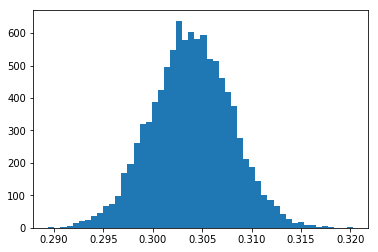

In [3]:
plt.hist(beta(3846.88, 8809.69, size=10000), bins=50);

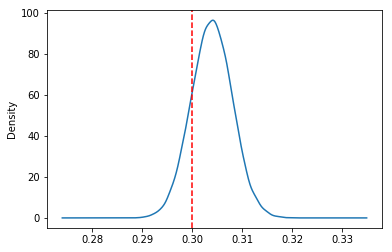

In [4]:
aaron = career_eb.loc['aaronha01'].to_dict()
d = beta(aaron['alpha1'], aaron['beta1'], size=10000)
pd.Series(d).plot.kde()
plt.axvline(.3, color='r', linestyle='--')

In [5]:
# Probability of Hank Aaron's true average being < .300
pbeta(3850., 8818., .3)

0.16919999999999999

Adding Posterior Error Probability to our dataframe.

In [6]:
# this code takes a bit to run (~18s) as we're generating Beta distributions with 10k observations for each player
career_eb = (career_eb
             .assign(PEP = lambda df: df.apply(lambda x: pbeta(x['alpha1'], x['beta1'], q=.3), axis=1))
            )

career_eb.head()

,name,H,AB,average,eb_estimate,alpha1,beta1,PEP
playerID,,,,,,,,
aaronha01,Hank Aaron,3771,12364,0.304998,0.303943,3846.88,8809.69,0.1688
aaronto01,Tommie Aaron,216,944,0.228814,0.236040,291.88,944.69,1.0000
abadan01,Andy Abad,2,21,0.095238,0.248366,77.88,235.69,0.9788
abadijo01,John Abadie,11,49,0.224490,0.254355,86.88,254.69,0.9697
abbated01,Ed Abbaticchio,772,3044,0.253614,0.254117,847.88,2488.69,1.0000


### Figure 5.2

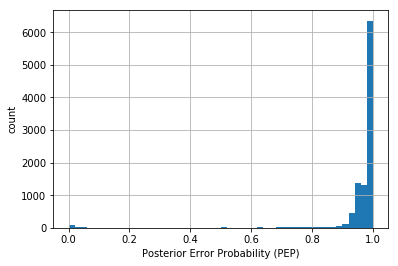

In [7]:
career_eb['PEP'].hist(bins=50)
plt.xlabel('Posterior Error Probability (PEP)')
plt.ylabel('count')

### Figure 5.3

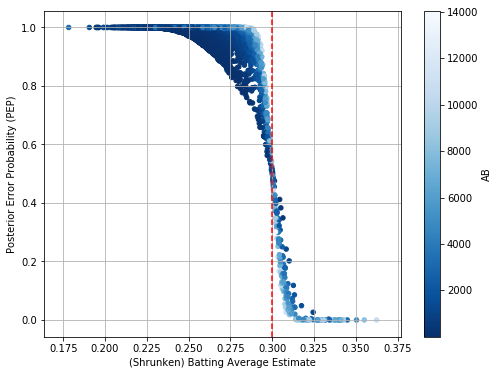

In [8]:
# recall that use of `sharex` is due to a bug (see Chapter 3)
career_eb.plot.scatter(x='eb_estimate', y='PEP', c='AB',
                       colormap='Blues_r', grid=True, figsize=(8,6),
                       sharex=False)
plt.axvline(.3, color='r', linestyle='--')
plt.xlabel('(Shrunken) Batting Average Estimate')
plt.ylabel('Posterior Error Probability (PEP)')

## Section 5.3 - False Discovery Rates

In [9]:
career_eb.sort_values(['PEP', 'eb_estimate'], ascending=[True, False])[:10]

,name,H,AB,average,eb_estimate,alpha1,beta1,PEP
playerID,,,,,,,,
cobbty01,Ty Cobb,3871,10598,0.365258,0.362413,3946.88,6943.69,0.0
hornsro01,Rogers Hornsby,2930,8173,0.358497,0.355071,3005.88,5459.69,0.0
jacksjo01,Shoeless Joe Jackson,1772,4981,0.355752,0.350404,1847.88,3425.69,0.0
odoulle01,Lefty O'Doul,1126,3192,0.352757,0.344915,1201.88,2282.69,0.0
delahed01,Ed Delahanty,2596,7505,0.345903,0.342655,2671.88,5125.69,0.0
speaktr01,Tris Speaker,3321,9624,0.345075,0.342546,3396.88,6519.69,0.0
willite01,Ted Williams,2461,7145,0.344437,0.341090,2536.88,4900.69,0.0
hamilbi01,Billy Hamilton,2158,6268,0.344288,0.340501,2233.88,4326.69,0.0
sislege01,George Sisler,1565,4528,0.345627,0.340391,1640.88,3179.69,0.0


In [10]:
career_eb.sort_values(['PEP', 'eb_estimate'], ascending=[True, False])[90:101]

,name,H,AB,average,eb_estimate,alpha1,beta1,PEP
playerID,,,,,,,,
falkbi01,Bibb Falk,1463,4652,0.314488,0.311226,1538.88,3405.69,0.0465
garcino01,Nomar Garciaparra,1747,5586,0.312746,0.310089,1822.88,4055.69,0.0471
grimera01,Ray Grimes,505,1537,0.328562,0.317495,580.88,1248.69,0.0488
pujolal01,Albert Pujols,2825,9138,0.309149,0.307604,2900.88,6529.69,0.0542
millebi02,Bing Miller,1934,6212,0.311333,0.308995,2009.88,4494.69,0.0548
tiernmi01,Mike Tiernan,1717,5499,0.312239,0.309567,1792.88,3998.69,0.0574
harrijo03,Joe Harris,963,3035,0.317298,0.312204,1038.88,2288.69,0.0638
lindsfr01,Freddie Lindstrom,1747,5611,0.311353,0.308776,1822.88,4080.69,0.0711
everibi01,Bill Everitt,902,2842,0.317382,0.311966,977.88,2156.69,0.0728


In [11]:
top_players = career_eb.sort_values('PEP')[:100]

# number of false positives we'd expect in top 100
print(top_players['PEP'].sum())

# average PEP of top 100
print(top_players['PEP'].mean())

1.3452
0.013452


In [12]:
# average PEP of top 50
print(career_eb.sort_values('PEP')[:50]['PEP'].mean())

# average PEP of top 200
print(career_eb.sort_values('PEP')[:200]['PEP'].mean())

6e-05
0.1402055


## Section 5.4 - Q-values

In [13]:
career_eb = career_eb.sort_values('PEP').assign(qvalue = lambda df: df['PEP'].cumsum())
career_eb.head()

,name,H,AB,average,eb_estimate,alpha1,beta1,PEP,qvalue
playerID,,,,,,,,,
odoulle01,Lefty O'Doul,1126,3192,0.352757,0.344915,1201.88,2282.69,0.0,0.0
oneilti01,Tip O'Neill,1289,3882,0.332045,0.326951,1364.88,2809.69,0.0,0.0
ricesa01,Sam Rice,2925,9064,0.322705,0.320724,3000.88,6355.69,0.0,0.0
hamilbi01,Billy Hamilton,2158,6268,0.344288,0.340501,2233.88,4326.69,0.0,0.0
foxxji01,Jimmie Foxx,2418,7443,0.324869,0.322391,2493.88,5241.69,0.0,0.0


How many players do we let into the Hall of Fame if we set the False Discovery Rate to 5%?

What about 1%?

In [14]:
hall_of_fame = career_eb.query("qvalue < .05")
print(len(hall_of_fame))

strict_hall_of_fame = career_eb.query("qvalue < .01")
print(len(strict_hall_of_fame))

68
55


### Figure 5.4

Feel like there has to be an easier way to make this plot. If you figure it out, let me know.

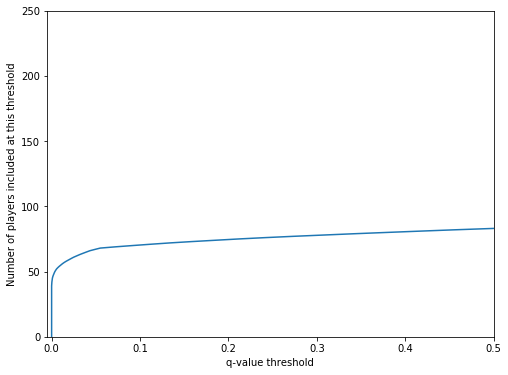

In [15]:
qvalues = career_eb.reset_index()['qvalue']

plt.figure(figsize=(8, 6))
plt.plot(qvalues.values, qvalues.index)
plt.xlim(-.005, .5)
plt.ylim(0, 250)
plt.xlabel('q-value threshold')
plt.ylabel('Number of players included at this threshold')

## Section 5.5 - Frequentists and Bayesians; meeting in the middle
No code or plots in this section